In [390]:
#General Import 

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn')
%matplotlib inline

In [391]:
#Import CSVs

#Import the data
import pandas as pd
confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", error_bad_lines=False)
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',  error_bad_lines=False)
#latest_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv")
#confirmed_df_alternativ = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")



In [392]:
#Import Population 

population_df = pd.read_csv("Population.csv", encoding = "ISO-8859-1") #World Population from UN

# Overview

First we create a static table to confirm the correct data import and get an overview


In [393]:


#Funcion to add deaths and recoveries to global dataframe, merging numbers either to province or country

import warnings
warnings.filterwarnings("ignore")

#input: global data frame
global_df_alt = confirmed_df_alternativ.iloc[:,[0,1,-1]] 
global_df_alt.columns = [*global_df_alt.columns[:-1], 'Confirmed']
dataframe = global_df_alt
add_column = "Number of Deaths"

#to merge: recoveries and death. Iterating through Countries and States. For sure there is a better method. 

def merge_column(dataframe, merge, add_column):
    merge = merge.iloc[:,[0,1,-1]]
    values = []
    for x, y in zip(dataframe["Province/State"], dataframe["Country/Region"]):
        if pd.isnull(x):
            if y in merge["Country/Region"].tolist():
                values.append((merge[merge["Country/Region"]== y].iloc[0,-1]))
            else:
                values.append(np.nan)
        else:
            if x in merge["Province/State"].tolist():
                values.append(merge[merge["Province/State"]== x].iloc[0,-1])
            else:
                values.append(np.nan)
    values
    dataframe[add_column] = values
    #dataframe[add_column] = global_df_alt[add_column].astype('Int64')
    return(dataframe)

#Add Columns "Deaths", "Recoveries" and calculate fields "Number of active Cases" and "Mortality Rate"

global_df_alt = merge_column(global_df_alt, deaths_df, "Number of Deaths")
global_df_alt = merge_column(global_df_alt, recoveries_df, "Number of Recoveries")
global_df_alt["Number of Active Cases"] = global_df_alt["Confirmed"]-global_df_alt["Number of Deaths"]-global_df_alt["Number of Recoveries"]
global_df_alt.rename(columns={"Country/Region": "Country Name", "Confirmed": "Number of Confirmed Cases"},inplace=True)
global_df_alt["Mortality Rate"] =  global_df_alt["Number of Deaths"] / global_df_alt["Number of Confirmed Cases"] 

#ONe global Database with all regions, and one grouped by country
global_regions = global_df_alt
global_countries = global_df_alt.groupby(["Country Name"]).sum().sort_values(by=["Number of Confirmed Cases", "Country Name"], ascending=[False, True])
global_countries = global_countries.reset_index()
global_countries.style.background_gradient(cmap='Greens')


,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,732197,42094,72329.000000,617774.000000,0.057490
1,Spain,191726,20852,80587.000000,90287.000000,0.108759
2,Italy,175925,24114,48877.000000,102934.000000,0.137070
3,France,149149,28,696.000000,148425.000000,0.210229
4,Germany,143342,4862,91500.000000,46980.000000,0.033919
5,United Kingdom,115314,46,483.000000,114785.000000,0.497477
6,China,83787,4636,77745.000000,1406.000000,0.367498
7,Turkey,82329,2140,13430.000000,66759.000000,0.025993
8,Iran,80868,5209,59273.000000,16386.000000,0.064414
9,Belgium,37183,5828,8895.000000,22460.000000,0.156738


# Visualisation - some Plots I had in in mind

First I choose the top ten countries from the overview table.
The time series will be normed for all countrys to Day 0 at 100 cases. 

Then a standard plot "Confirmed" over time.

Then "Confirmed" over new cases, it is interesing to see how measures affect differently. 

In [446]:
#PLOTS

#Which countries we want to plot?
#by default TOP10 Confirmed Cases

#Get List with Top Ten Countries

top_ten_countries = global_countries["Country Name"].head(10).tolist()
#selected_country=["US", "China"
selected_countries = top_ten_countries
print("Top 10 Countries:", selected_countries)


#Sum up Timeline in confirmed_df sum over group by country
 
confirmed = confirmed_df.groupby(['Country/Region']).sum()
confirmed = confirmed.reset_index()
#Get Index from selected countries in confirmed_countries


index_selected = []
for i in selected_countries:
    for j in range(len(confirmed.index)):
        if confirmed.iloc[j,0]== i:
            index_selected.append(j)



#Prepare Plotting:
#Get nested list with cases timeline for each selected country
cols = confirmed_df.columns[4::]
selected_countries_values = confirmed_countries.loc[index_selected, cols].to_numpy()




Top 10 Countries: ['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'China', 'Turkey', 'Iran', 'Belgium']


In [448]:


#Integer for time series

#Day Index
cols = confirmed_df.columns
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)




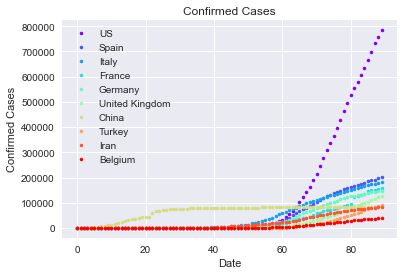

In [449]:
#Plot over Time
from matplotlib.pyplot import cm
plt.figure()
plt.title('Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
infected = []
a = selected_countries_values
color=cm.rainbow(np.linspace(0,1,len(a)))
for c in range(len(a)):
        infected = a[c]
        f = color[c]
        #diffinfected = [infected[ii+1]-infected[ii] for ii in range(len(infected)-1)]
        plt.plot(days_since_1_22,infected,'.', label = selected_countries[c], c = f)
        
plt.legend()
plt.show()


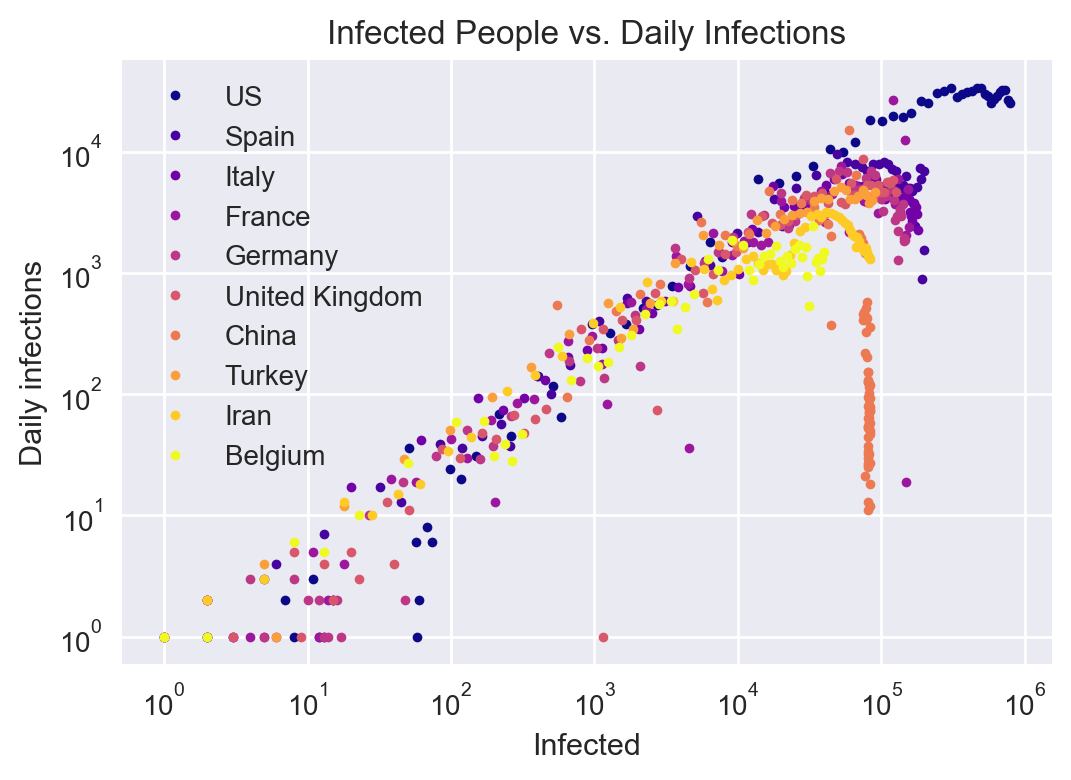

In [450]:
#Plot Infektionen Über Neu Infektionen
plt.rcParams['figure.dpi'] = 200

plt.figure()
plt.title('Infected People vs. Daily Infections')
plt.xscale('log')
plt.xlabel('Infected')
plt.yscale('log')
plt.ylabel('Daily infections')
color=cm.plasma(np.linspace(0,1,len(a)))
a = selected_countries_values
confirmed_selected = a
for c in range(len(a)):
        diffinfected = []
        for d in range(len(a[0])):
            if d == 0:
                diffinfected.append(confirmed_selected[c][0])
            else:   
                diffinfected.append(confirmed_selected[c][d]-confirmed_selected[c][(d-1)])
        f = color[c]
        plt.plot(confirmed_selected[c], diffinfected,'.', label = selected_countries[c],c=f)
plt.legend()

In [451]:
#Bring all datasets on one timesampe (count days), starting with f(d=0) = 25 infections
a = selected_countries_values


selected_countries_confirmed=[]
for i in range(len(a)):
    selected_countries_confirmed.append(np.array( [item for item in a[i] if item > 25]))


#Build a list with counting integer and the same length as confirmed cases per country 
a = selected_countries_confirmed
days_selected = []
for i in range(len(a)):
    days_selected.append(np.array([item for item in range(len(a[i]))]))

    
selected_countries_confirmed

[array([    51,     51,     57,     58,     60,     68,     74,     98,
           118,    149,    217,    262,    402,    518,    583,    959,
          1281,   1663,   2179,   2727,   3499,   4632,   6421,   7783,
         13747,  19273,  25600,  33276,  43843,  53736,  65778,  83836,
        101657, 121465, 140909, 161831, 188172, 213372, 243762, 275586,
        308853, 337072, 366667, 397505, 429052, 462780, 496535, 526396,
        555313, 580619, 607670, 636350, 667592, 699706, 732197, 759086,
        784326], dtype=int64),
 array([    32,     45,     84,    120,    165,    222,    259,    400,
           500,    673,   1073,   1695,   2277,   2277,   5232,   6391,
          7798,   9942,  11748,  13910,  17963,  20410,  25374,  28768,
         35136,  39885,  49515,  57786,  65719,  73235,  80110,  87956,
         95923, 104118, 112065, 119199, 126168, 131646, 136675, 141942,
        148220, 153222, 158273, 163027, 166831, 170099, 172541, 177644,
        184948, 190839, 191726, 1

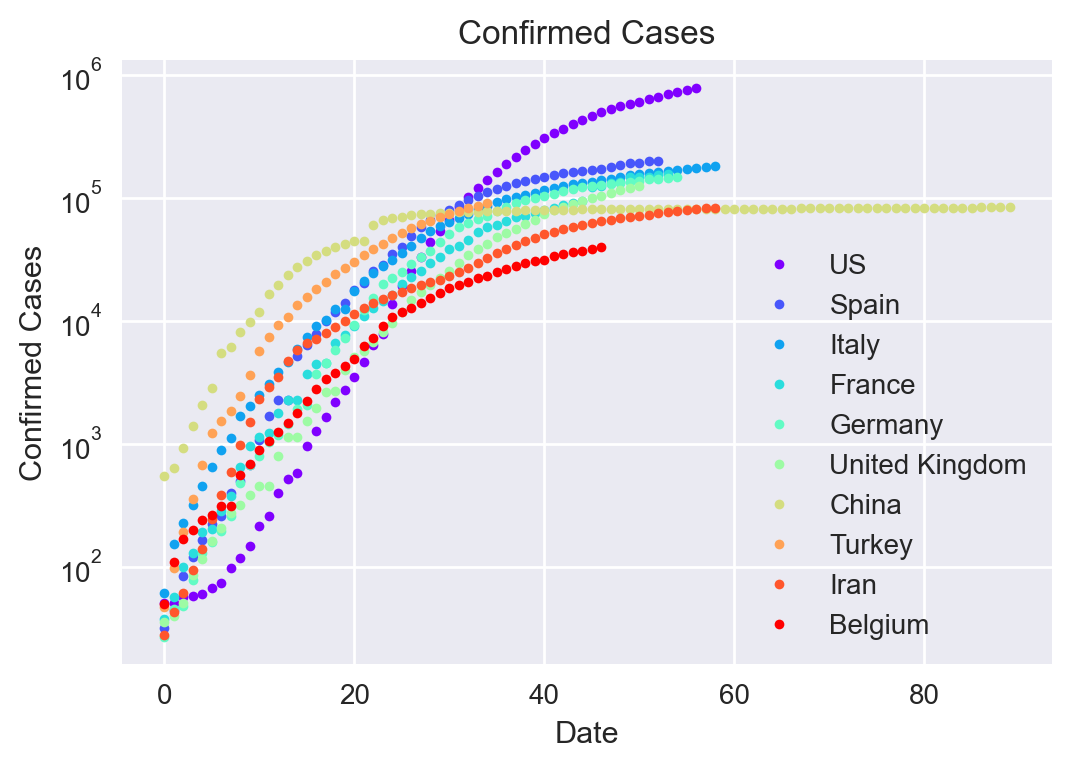

In [452]:
#Plot over Time
from matplotlib.pyplot import cm
plt.figure()
plt.title('Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.yscale('log')
infected = []
a = selected_countries_confirmed
color=cm.rainbow(np.linspace(0,1,len(a)))
for c in range(len(a)):
        infected = a[c]
        days = days_selected[c]
        f = color[c]
        #diffinfected = [infected[ii+1]-infected[ii] for ii in range(len(infected)-1)]
        plt.plot(days,infected,'.', label = selected_countries[c], c = f)
        
plt.legend()
plt.show()